In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, gcf
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, auc, roc_curve
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from xgboost import plot_importance
import lightgbm as lgb
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
import keras.backend as K
from tensorflow import set_random_seed

In [0]:
seed = 7
np.random.seed(seed)
set_random_seed(2)

In [3]:
df = pd.read_excel('CAD.xlsx')
df.head()

,Age,Weight,Length,Sex,BMI,DM,HTN,Current Smoker,EX-Smoker,FH,...,K,Na,WBC,Lymph,Neut,PLT,EF-TTE,Region RWMA,VHD,Cath
0,53,90,175,Male,29.387755,0,1,1,0,0,...,4.7,141,5700,39,52,261,50,0,N,Cad
1,67,70,157,Fmale,28.398718,0,1,0,0,0,...,4.7,156,7700,38,55,165,40,4,N,Cad
2,54,54,164,Male,20.077335,0,0,1,0,0,...,4.7,139,7400,38,60,230,40,2,mild,Cad
3,66,67,158,Fmale,26.838648,0,1,0,0,0,...,4.4,142,13000,18,72,742,55,0,Severe,Normal
4,50,87,153,Fmale,37.165193,0,1,0,0,0,...,4.0,140,9200,55,39,274,50,0,Severe,Normal


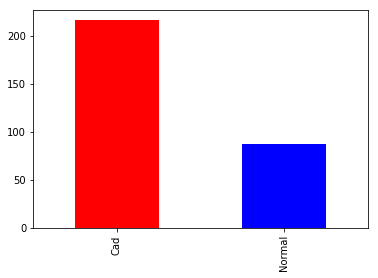

In [70]:
df.Cath.value_counts().plot.bar(color=['r','b'])
plt.show()

In [0]:
X = df.drop(['Cath'], axis=1)
Y = df['Cath']
X = pd.get_dummies(X)
encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

In [0]:
skf = StratifiedKFold(n_splits=4, shuffle=False, random_state=8)

In [72]:
XGB = XGBClassifier(n_estimators=70, objective='binary:logistic',
                    scale_pos_weight=4,
                    seed=7)
pred = []
pred_ = []
for fold, (trn_idx, val_idx) in enumerate(skf.split(X, Y)):
    Xtrain, Ytrain = X.iloc[trn_idx], Y[trn_idx]
    Xtest, Ytest = X.iloc[val_idx], Y[val_idx]
    XGB.fit(Xtrain, Ytrain)
    p = XGB.predict_proba(Xtest)
    for pp in p:
        pred.append(pp[1])
        if pp[1]>0.5:
          pred_.append(1)
        else:
          pred_.append(0)

print('Accuracy:    ' , accuracy_score(Y, pred_))
print('F_Measure:   ', f1_score(Y, pred_))
fpr, tpr, thresholds = roc_curve(Y, pred)
print('AUC:         ', auc(fpr, tpr))
print(confusion_matrix(Y, pred_))

Accuracy:     0.7392739273927392
F_Measure:    0.5775401069518717
AUC:          0.7257343550447
[[170  46]
 [ 33  54]]


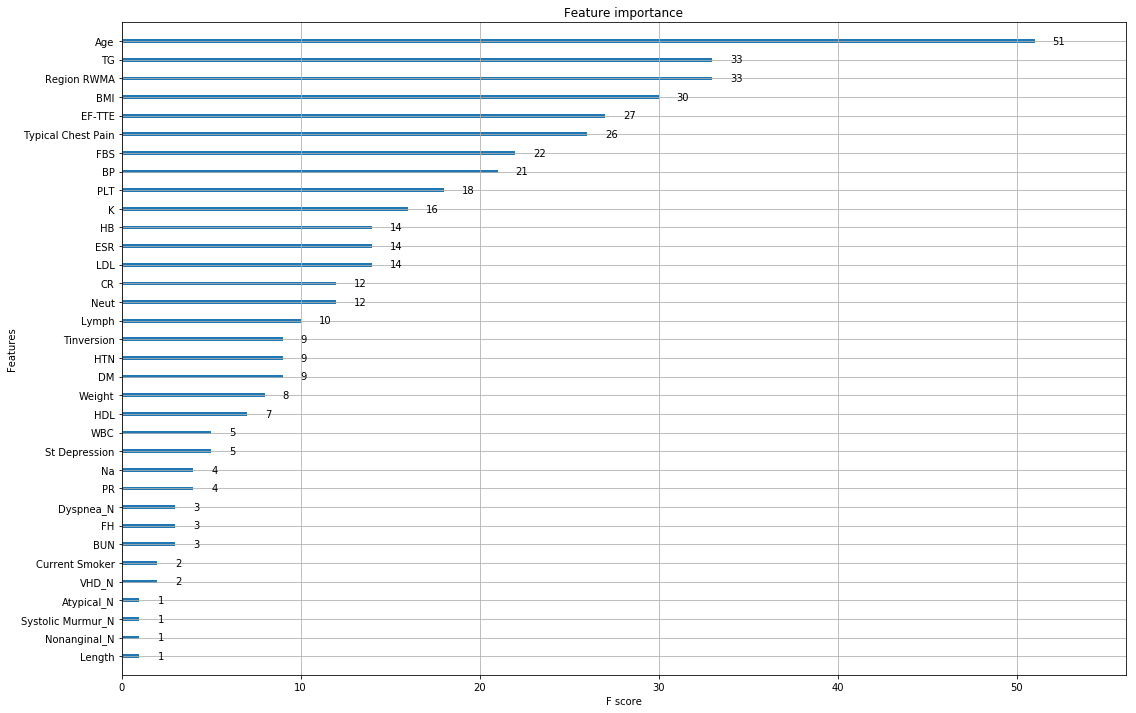

In [92]:
# feature importance
plt.rcParams["figure.figsize"] = (18,12)
plot_importance(XGB)
plt.show()

In [73]:
gbm = lgb.LGBMClassifier(n_estimators=10000, silent=True, subsample=0.85, colsample_bytree=0.85, learning_rate=0.009)

pred = []
pred_ = []
for fold, (trn_idx, val_idx) in enumerate(skf.split(X, Y)):
    Xtrain, Ytrain = X.iloc[trn_idx], Y[trn_idx]
    Xtest, Ytest = X.iloc[val_idx], Y[val_idx]
    gbm.fit(Xtrain, Ytrain, eval_set=[(Xtest, Ytest)], early_stopping_rounds=100, verbose=False)
    p = gbm.predict_proba(Xtest, num_iteration=gbm.best_iteration_)
    for pp in p:
        pred.append(pp[1])
        if pp[1]>0.5:
          pred_.append(1)
        else:
          pred_.append(0)

print('Accuracy:    ' , accuracy_score(Y, pred_))
print('F_Measure:   ', f1_score(Y, pred_))
fpr, tpr, thresholds = roc_curve(Y, pred)
print('AUC:         ', auc(fpr, tpr))
print(confusion_matrix(Y, pred_))

Accuracy:     0.7392739273927392
F_Measure:    0.5031446540880503
AUC:          0.7137611749680716
[[184  32]
 [ 47  40]]


In [0]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [0]:
def create_baseline():
  model = Sequential()
  model.add(Dense(20, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
  model.add(Dropout(0.1)) 
  model.add(Dense(25, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
  model.add(Dropout(0.1)) 
  model.add(Dense(20, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(10, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
  model.add(Dropout(0)) 
  model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1])
  return model

In [74]:
pred = []
pred_ = []
for fold, (trn_idx, val_idx) in enumerate(skf.split(X, Y)):
    Xtrain, Ytrain = X.iloc[trn_idx], Y[trn_idx]
    Xtest, Ytest = X.iloc[val_idx], Y[val_idx]
    model = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=4, verbose=0, validation_data=(Xtest, Ytest))
    model.fit(Xtrain,Ytrain)
    p = model.predict_proba(Xtest)
    for pp in p:
        pred.append(pp[1])
        if pp[1]>0.5:
          pred_.append(1)
        else:
          pred_.append(0)

print('Accuracy:    ' , accuracy_score(Y, pred_))
print('F_Measure:   ', f1_score(Y, pred_))
fpr, tpr, thresholds = roc_curve(Y, pred)
print('AUC:         ', auc(fpr, tpr))
print(confusion_matrix(Y, pred_))

Accuracy:     0.7260726072607261
F_Measure:    0.36641221374045796
AUC:          0.7072424435930182
[[196  20]
 [ 63  24]]
